# Topology (Persistent Homology) Detector on Geometrical Point Clouds

This notebook demonstrates the **public pipeline API** (`src/api.py`) on the
**GeometricalPointCloudDatasetSpec** (registry key: `geometrical-shapes`).

We run the standard flow:
- load dataset via the registry
- train a classifier
- generate adversarial examples
- compute graph/topology scores
- fit a topology-score detector
- evaluate detection metrics (AUROC/AUPRC/FPR@95%TPR)


In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Ensure repo root on path
cwd = Path.cwd().resolve()
project_root = cwd if (cwd / "src").is_dir() else (cwd.parent if (cwd.parent / "src").is_dir() else cwd)
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src import api
from src.utils import ExperimentConfig, set_seed
from src.visualization import plot_roc_from_metrics, plot_score_distributions_figure

print("PROJECT_ROOT:", project_root)
print("Available datasets (subset):", [d for d in api.list_datasets() if "geo" in d or "point" in d or "shape" in d])


PROJECT_ROOT: /Users/svenhockers/Desktop/pipeline
Available datasets (subset): ['geometrical-shapes', 'synthetic_shapes_2class', 'synthetic_shapes_3class']


## Configure experiment

Note: the dataset type is selected via `cfg.data.dataset_type` (not a built-in `DataConfig` field),
so we set it directly on the config object.


In [2]:
SEED = 42
set_seed(SEED)

cfg = ExperimentConfig(seed=SEED, device="cpu")

# Dataset controls
cfg.data.n_samples = 2500
cfg.data.noise = 0.1
cfg.data.train_ratio = 0.6
cfg.data.val_ratio = 0.2
cfg.data.test_ratio = 0.2

# Select a geometrical dataset variant
# Options in src/data.py: 'torus_one_hole', 'torus_two_holes', 'nested_spheres', 'Blobs'
cfg.data.dataset_type = "torus_one_hole"

# Model training — frozen model config
cfg.model.hidden_dims = [256, 128]
cfg.model.epochs = 40
cfg.model.learning_rate = 1e-3
cfg.model.weight_decay = 0.0
cfg.model.batch_size = 64

# Attack
# IMPORTANT: use PGD (FGSM is often too weak here => ~0 successful attacks => AUROC ~0.5)
cfg.attack.attack_type = "pgd"
cfg.attack.epsilon = 0.30
cfg.attack.num_steps = 50
cfg.attack.step_size = cfg.attack.epsilon / 10.0
cfg.attack.random_start = True

# Scoring / topology
# For 3D point clouds, start in input space (feature space is optional).
cfg.graph.space = "input"  # 'input' or 'feature'
cfg.graph.feature_layer = "penultimate"  # used only when space == 'feature'

cfg.graph.use_topology = True
cfg.graph.use_tangent = False
cfg.graph.topo_k = 150
cfg.graph.topo_maxdim = 2
cfg.graph.topo_preprocess = "none"  # 'none' or 'pca'
cfg.graph.topo_pca_dim = 3  # only used when topo_preprocess == 'pca'
cfg.graph.topo_min_persistence = 1e-6

# Detector
cfg.detector.detector_type = "topology_score"
cfg.detector.topo_percentile = 95.0
cfg.detector.topo_cov_shrinkage = 1e-3


## Load dataset and visualize


(3840, 3)
(960, 3)
(3840,)
(960,)
dataset_type: torus_one_hole
X_train: (3840, 3) | y_train classes: [0, 1]


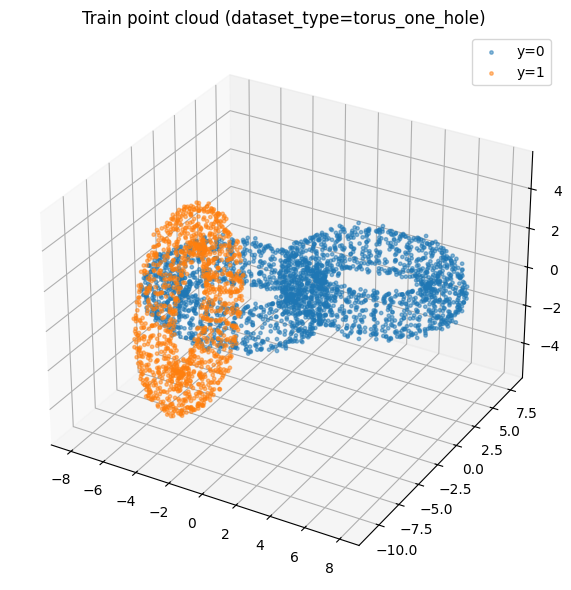

In [4]:
bundle = api.get_dataset("geometrical-shapes", cfg)
X_train, y_train = bundle.X_train, bundle.y_train
X_val, y_val = bundle.X_val, bundle.y_val
X_test, y_test = bundle.X_test, bundle.y_test

print("dataset_type:", bundle.meta.get("dataset_type"))
print("X_train:", X_train.shape, "| y_train classes:", sorted(set(int(x) for x in np.unique(y_train))))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
for cls in sorted(int(c) for c in np.unique(y_train)):
    m = (y_train == cls)
    pts = X_train[m]
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=6, alpha=0.5, label=f"y={cls}")
ax.set_title(f"Train point cloud (dataset_type={bundle.meta.get('dataset_type')})")
ax.legend()
plt.tight_layout(); plt.show()


## Train model (API)


In [5]:
cfg.model.input_dim = int(X_train.shape[1])
cfg.model.output_dim = int(bundle.meta.get("num_classes", 2))

model = api.get_model(
    "two_moons_mlp",
    cfg,
    input_dim=cfg.model.input_dim,
    output_dim=cfg.model.output_dim,
)

model = api.train(model, bundle, cfg, device=str(cfg.device), verbose=True, return_history=False)

pred_test = api.predict(model, X_test, device=str(cfg.device), return_probs=False)
test_acc = 100.0 * float(np.mean(pred_test == np.asarray(y_test, dtype=int)))
print(f"Test accuracy: {test_acc:.2f}%")


Epoch [10/40] Train Loss: 0.0236, Train Acc: 99.56%, Val Loss: 0.0164, Val Acc: 99.44%
Epoch [20/40] Train Loss: 0.0113, Train Acc: 99.74%, Val Loss: 0.0031, Val Acc: 100.00%
Epoch [30/40] Train Loss: 0.0021, Train Acc: 100.00%, Val Loss: 0.0022, Val Acc: 100.00%
Epoch [40/40] Train Loss: 0.0013, Train Acc: 99.97%, Val Loss: 0.0006, Val Acc: 100.00%
Test accuracy: 100.00%


## Adversarial examples + detector (API)


Val successful attacks:  22/720 = 0.031
Test successful attacks: 6/240 = 0.025

Detector metrics:
  AUROC:     0.7708
  AUPRC:     0.0857
  FPR@95TPR: 0.4750
  threshold: 3.2311


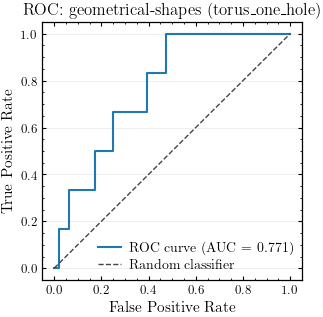

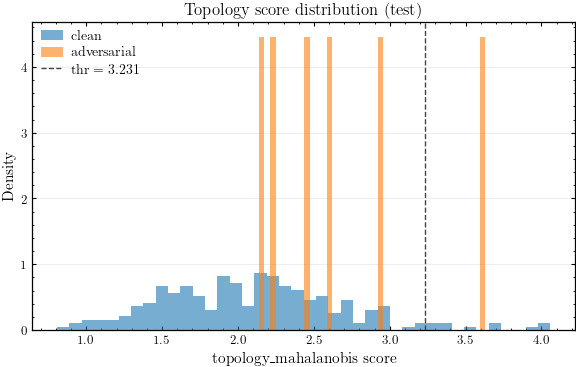

(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': '\\textnormal{Topology score distribution (test)}'}, xlabel='\\textnormal{topology\\_mahalanobis score}', ylabel='\\textnormal{Density}'>)

In [6]:
# Generate adversarial examples
X_adv_val = api.generate_adversarial(model, X_val, y_val, cfg)
X_adv_test = api.generate_adversarial(model, X_test, y_test, cfg)

# Optional evaluation restrictions
FILTER_CLEAN_TO_CORRECT = True
EVAL_ONLY_SUCCESSFUL_ATTACKS = True

clean_mask_val = np.ones(len(X_val), dtype=bool)
clean_mask_test = np.ones(len(X_test), dtype=bool)
if FILTER_CLEAN_TO_CORRECT:
    pred_val = api.predict(model, X_val, device=str(cfg.device), return_probs=False)
    pred_test = api.predict(model, X_test, device=str(cfg.device), return_probs=False)
    clean_mask_val = pred_val == np.asarray(y_val, dtype=int)
    clean_mask_test = pred_test == np.asarray(y_test, dtype=int)

adv_mask_val = np.ones(len(X_adv_val), dtype=bool)
adv_mask_test = np.ones(len(X_adv_test), dtype=bool)
if EVAL_ONLY_SUCCESSFUL_ATTACKS:
    adv_mask_val = api.attack_success_mask(model, X_val, X_adv_val, y_val, device=str(cfg.device))
    adv_mask_test = api.attack_success_mask(model, X_test, X_adv_test, y_test, device=str(cfg.device))

print(f"Val successful attacks:  {adv_mask_val.sum()}/{len(adv_mask_val)} = {adv_mask_val.mean():.3f}")
print(f"Test successful attacks: {adv_mask_test.sum()}/{len(adv_mask_test)} = {adv_mask_test.mean():.3f}")

# If there are *zero* successful attacks, fall back to evaluating on all adversarial points.
# Otherwise downstream scoring will see empty arrays and fail.
if EVAL_ONLY_SUCCESSFUL_ATTACKS and adv_mask_val.sum() == 0:
    print("WARNING: no successful VAL attacks; falling back to all adversarial points for VAL.")
    adv_mask_val = np.ones(len(X_adv_val), dtype=bool)
if EVAL_ONLY_SUCCESSFUL_ATTACKS and adv_mask_test.sum() == 0:
    print("WARNING: no successful TEST attacks; falling back to all adversarial points for TEST.")
    adv_mask_test = np.ones(len(X_adv_test), dtype=bool)

# Subsample for PH runtime
MAX_POINTS_FOR_SCORING = 250
X_val_clean_used, _ = api.subsample_masked(X_val, y_val, clean_mask_val, MAX_POINTS_FOR_SCORING, seed=SEED)
X_val_adv_used, _ = api.subsample_masked(X_adv_val, y_val, adv_mask_val, MAX_POINTS_FOR_SCORING, seed=SEED + 1)
X_test_clean_used, _ = api.subsample_masked(X_test, y_test, clean_mask_test, MAX_POINTS_FOR_SCORING, seed=SEED + 2)
X_test_adv_used, _ = api.subsample_masked(X_adv_test, y_test, adv_mask_test, MAX_POINTS_FOR_SCORING, seed=SEED + 3)

# Scores
# (Defensive: avoid empty scoring sets)
if len(X_val_adv_used) == 0:
    raise RuntimeError("X_val_adv_used is empty after masking/subsampling. Increase epsilon or disable EVAL_ONLY_SUCCESSFUL_ATTACKS.")
if len(X_test_adv_used) == 0:
    raise RuntimeError("X_test_adv_used is empty after masking/subsampling. Increase epsilon or disable EVAL_ONLY_SUCCESSFUL_ATTACKS.")

scores_val_clean = api.compute_scores(X_val_clean_used, model, bundle=bundle, cfg=cfg)
scores_val_adv = api.compute_scores(X_val_adv_used, model, bundle=bundle, cfg=cfg)
scores_test_clean = api.compute_scores(X_test_clean_used, model, bundle=bundle, cfg=cfg)
scores_test_adv = api.compute_scores(X_test_adv_used, model, bundle=bundle, cfg=cfg)

# Fit detector on validation
scores_val_all = api.concat_scores(scores_val_clean, scores_val_adv)
any_key = next(iter(scores_val_all.keys()))
labels_val = np.concatenate([
    np.zeros(len(scores_val_clean[any_key]), dtype=int),
    np.ones(len(scores_val_adv[any_key]), dtype=int),
])
detector = api.fit_detector(scores_val_all, labels_val, cfg)

# Evaluate on test
scores_test_all = api.concat_scores(scores_test_clean, scores_test_adv)
any_key_t = next(iter(scores_test_all.keys()))
labels_test = np.concatenate([
    np.zeros(len(scores_test_clean[any_key_t]), dtype=int),
    np.ones(len(scores_test_adv[any_key_t]), dtype=int),
])
raw_scores_test = np.asarray(detector.score(scores_test_all), dtype=float)
metrics = api.evaluate_detection(labels_test, raw_scores_test)

print("\nDetector metrics:")
print(f"  AUROC:     {metrics['roc_auc']:.4f}")
print(f"  AUPRC:     {metrics['pr_auc']:.4f}")
print(f"  FPR@95TPR: {metrics['fpr_at_tpr95']:.4f}")
print(f"  threshold: {float(getattr(detector, 'threshold', np.nan)):.4f}")

# Quick visualizations
plot_roc_from_metrics(metrics, title=f"ROC: geometrical-shapes ({bundle.meta.get('dataset_type')})")
thr = float(getattr(detector, 'threshold', np.nan))
raw_clean = raw_scores_test[: len(scores_test_clean[any_key_t])]
raw_adv = raw_scores_test[len(scores_test_clean[any_key_t]):]
plot_score_distributions_figure(
    raw_clean,
    raw_adv,
    score_name="topology_mahalanobis score",
    title="Topology score distribution (test)",
    bins=40,
    threshold=thr,
    labels=("clean", "adversarial"),
    alpha=0.6,
    density=True,
    figsize=(7, 4),
)
